In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


pd.set_option("display.max_rows", 50)
pd.set_option("display.max_columns", 50)
pd.set_option("display.max_colwidth", 1000)


### Reading the dataset


In [2]:
files = [
    "data/yahoo-news-annotated-comments-dataset/ydata-ynacc-v1_0_expert_annotations.tsv",
    "data/yahoo-news-annotated-comments-dataset/ydata-ynacc-v1_0_turk_annotations.tsv",
]

datasets = []
for file in files:
    datasets.append(pd.read_csv(file, sep="\t"))

yahoo_df = pd.concat(datasets, axis=0, ignore_index=True)


In [3]:
print(yahoo_df.shape)
yahoo_df.head()


(48915, 20)


,sdid,commentindex,headline,url,guid,commentid,timestamp,thumbs-up,thumbs-down,text,parentid,constructiveclass,sd_agreement,sd_type,sentiment,tone,commentagreement,topic,intendedaudience,persuasiveness
0,53971,2,Disneyland Worker Found Dead in Haunted Mansion,http://www.cosmopolitan.com/lifestyle/news/a56215/disneyland-paris-haunted-mansion-death/,rjrPtwH5oVVuQnEXX3hf,00003n000000000000000000000000-ed2ae6d0-32ac-471a-b8b2-a718607ee376,1459917444,NaN,NaN,"These things happen , Every job has its dangers.",1459879464596-a3771c05-fd2e-4f44-a26a-23baec3b4249,Constructive,NaN,Positive/respectful,negative,NaN,Disagreement with commenter,Off-topic with article,Reply to a specific commenter,Not persuasive
1,53971,0,Disneyland Worker Found Dead in Haunted Mansion,http://www.cosmopolitan.com/lifestyle/news/a56215/disneyland-paris-haunted-mansion-death/,VaW6HEsuOFUAIBqjw1k~,1459879464596-a3771c05-fd2e-4f44-a26a-23baec3b4249,1459879464,1.0,NaN,"Sad to hear such a bad thing. Very dangerous job working on electricity. One questions though, why did they use a picture the Bates house from Psycho, on a Disney story? Or is that what the Paris Haunted Mansion/Phantom Manor looks like?",NaN,Constructive,NaN,Positive/respectful,mixed,NaN,NaN,Off-topic with article,Broadcast message / general audience,Not persuasive
2,53971,1,Disneyland Worker Found Dead in Haunted Mansion,http://www.cosmopolitan.com/lifestyle/news/a56215/disneyland-paris-haunted-mansion-death/,uwQePj970KaMZuW3~9Q9,00002n000000000000000000000000-1c30b878-b717-4e9a-9872-2ce2906ce783,1459881644,NaN,NaN,Yes..because too many houses in EU look like the original Disney Hunted House so it didn't look scary enough. Bates Motel looks more American and that notion alone scares everyone.,1459879464596-a3771c05-fd2e-4f44-a26a-23baec3b4249,Constructive,NaN,Positive/respectful,neutral,Informative,NaN,Off-topic with article,Reply to a specific commenter,Not persuasive
3,135929,0,This Old Navy Ad Featuring an Interracial Family Is Being Attacked By Racist Trolls,http://mic.com/articles/142323/this-old-navy-ad-featuring-an-interracial-family-is-being-attacked-by-racist-trolls,fixyWJivQjEQtPLLVXsu,1462203719963-3eeffb02-faae-4b51-9174-704c57e6de37,1462203719,18.0,3.0,"I am frankly quite SICK of the phrase ""shoved down our throat"" You know what? Back in the newspaper and three network days you could say that...Now with 300 or more TV channels and an endless internet...You can keep your throat relatively clear of things you don't want...All you have to do is change the channel or click a link to something you DO like... So let's stop it with the ""shoved down our throat"" rhetoric.",NaN,Not constructive,Agreement throughout,Off-topic/digression,negative,Mean,NaN,Off-topic with article,Broadcast message / general audience,Persuasive
4,135929,1,This Old Navy Ad Featuring an Interracial Family Is Being Attacked By Racist Trolls,http://mic.com/articles/142323/this-old-navy-ad-featuring-an-interracial-family-is-being-attacked-by-racist-trolls,_TDnK715vO5y0OzZz_n4,00002I000000000000000000000000-7ef2ac58-bd84-4027-88cf-b865bfe2f1f8,1462204643,7.0,2.0,"Ya, I always wonder why the conservatives are on Yahoo!, whining about all the liberals, when they could be hanging out with their own kind, patting each other on the back, over at Faux News. Don't like what you see, switch the channel. No, they're a bit hypocritical about shoving things down peoples throats, and want to force they're way upon others.",1462203719963-3eeffb02-faae-4b51-9174-704c57e6de37,Not constructive,Agreement throughout,Off-topic/digression,neutral,Sarcastic,Agreement with commenter,Off-topic with article,Reply to a specific commenter,Not persuasive


### Building the comment threads at each comment level in the dataset


In [4]:
import string

import contractions
from num2words import num2words


def numbers_to_words(text: str) -> str:
    t = text.split()
    for ind, word in enumerate(t):
        if all(c.isdigit() for c in word):
            t[ind] = num2words(word)
        elif (
            len(word) > 2
            and all(c.isdigit() for c in word[:-2])
            and word[-2:] in ["st", "nd", "rd", "th"]
        ):
            t[ind] = num2words(int(word[:-2]), to="ordinal")

    return " ".join(t)


def build_comment_thread(row: pd.Series) -> str:
    if not row["text"]:
        return ""
    if row["text"][-1] not in string.punctuation:
        row["text"] += "."

    if row["commentindex"] != 0:
        parent_df = yahoo_df[yahoo_df.commentid == row["parentid"]]
        if parent_df.shape[0] == 0:
            return f"{row['headline']}. {row['text']}"
        else:
            return f"{parent_df.iloc[0].thread}. {row['text']}"
    else:
        return row["text"]


yahoo_df["text"] = (
    yahoo_df["text"]
    .str.replace(r"[^\w\s]+", "", regex=True)
    .str.replace(r"\s+", " ", regex=True)
    .str.replace("..", ".", regex=False)
    .str.strip()
    .str.lower()
    .apply(lambda x: contractions.fix(x, slang=False))
    .apply(numbers_to_words)
    .astype(str)
)
yahoo_df = yahoo_df.sort_values(by=["commentindex"])
yahoo_df["thread"] = ""
for index, row in yahoo_df.iterrows():
    yahoo_df.at[index, "thread"] = build_comment_thread(row)


### Splitting the dataset


In [5]:
with open(
    "data/yahoo-news-annotated-comments-dataset/ydata-ynacc-v1_0_train-ids.txt"
) as f:
    train_ids = [int(x) for x in f.read().splitlines()]

with open(
    "data/yahoo-news-annotated-comments-dataset/ydata-ynacc-v1_0_dev-ids.txt"
) as f:
    dev_ids = [int(x) for x in f.read().splitlines()]

with open(
    "data/yahoo-news-annotated-comments-dataset/ydata-ynacc-v1_0_test-ids.txt"
) as f:
    test_ids = [int(x) for x in f.read().splitlines()]

train_df = yahoo_df[yahoo_df["sdid"].isin(train_ids)].copy(deep=True)
dev_df = yahoo_df[yahoo_df["sdid"].isin(dev_ids)].copy(deep=True)
test_df = yahoo_df[yahoo_df["sdid"].isin(test_ids)].copy(deep=True)


### Visualizing the dataset


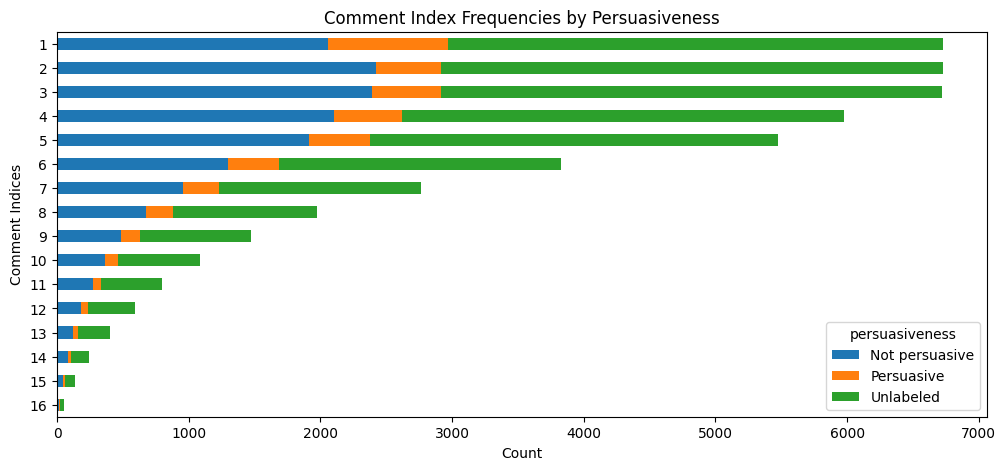

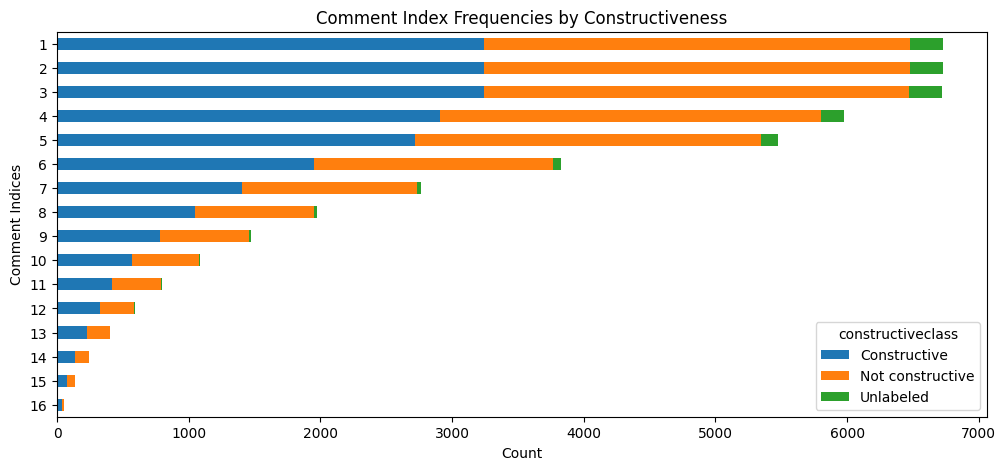

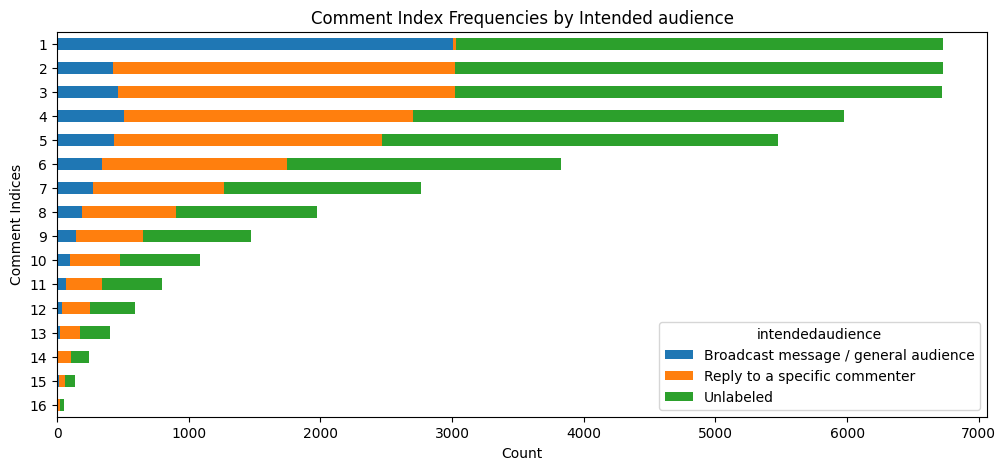

In [6]:
cols = [
    ("persuasiveness", "Persuasiveness"),
    ("constructiveclass", "Constructiveness"),
    ("intendedaudience", "Intended Audience"),
]
for column_name, display_name in cols:
    data = (
        train_df.fillna("Unlabeled")
        .groupby(["commentindex", column_name])["sdid"]
        .count()
        .reset_index()
    )
    data["commentindex"] += 1
    data = pd.pivot_table(
        data, values="sdid", index=["commentindex"], columns=[column_name]
    )
    data = data.sort_values(by="commentindex", ascending=False)

    fig, ax = plt.subplots(figsize=(12, 5))
    data.plot(kind="barh", stacked=True, ax=ax)
    ax.set(ylabel="Comment Indices", xlabel="Count")
    ax.set_title(f"Comment Index Frequencies by {display_name.capitalize()}")
plt.show()


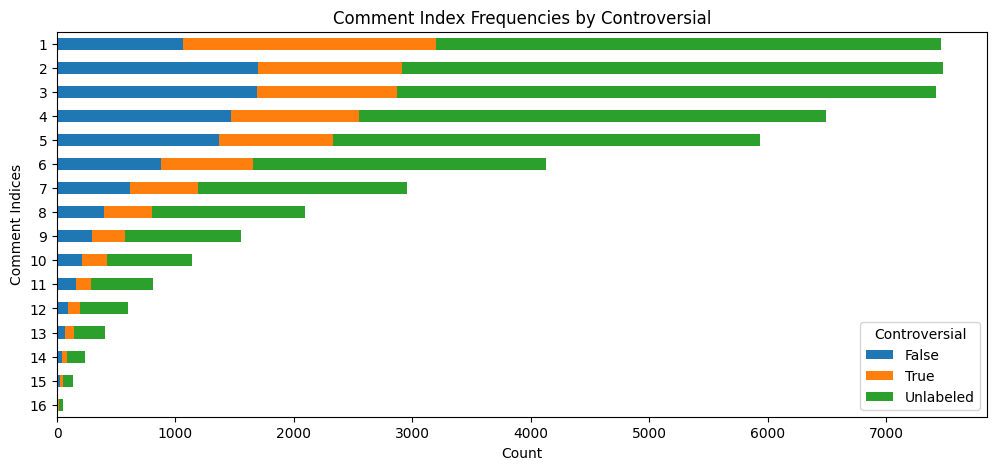

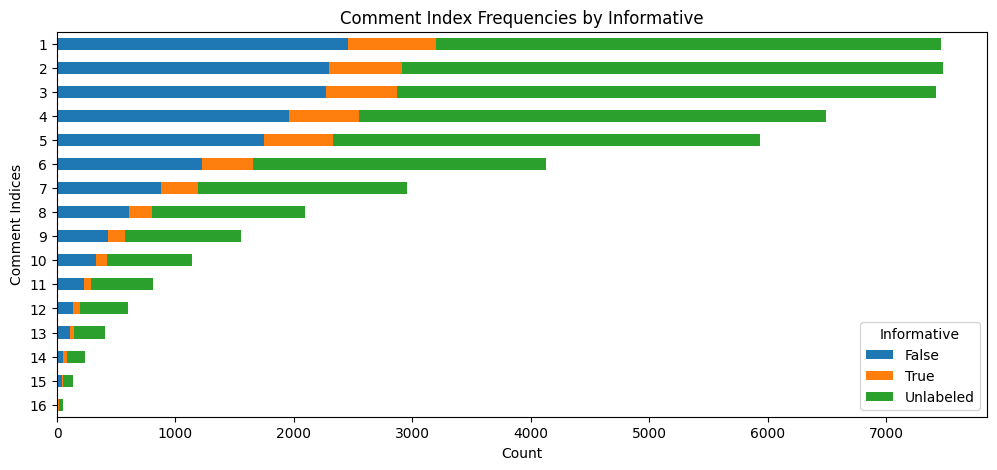

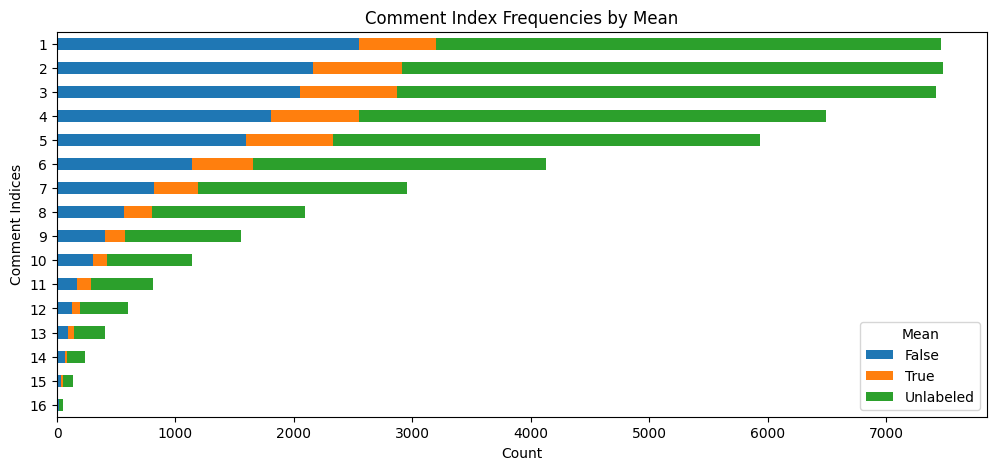

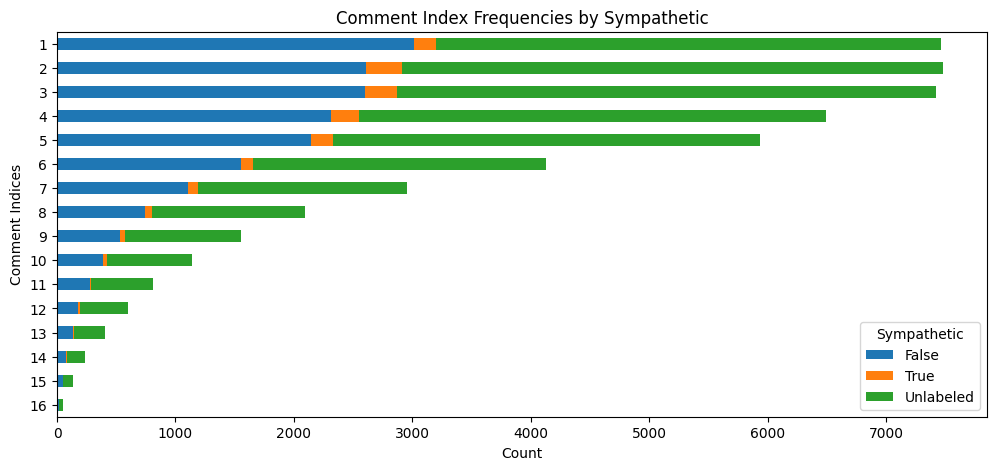

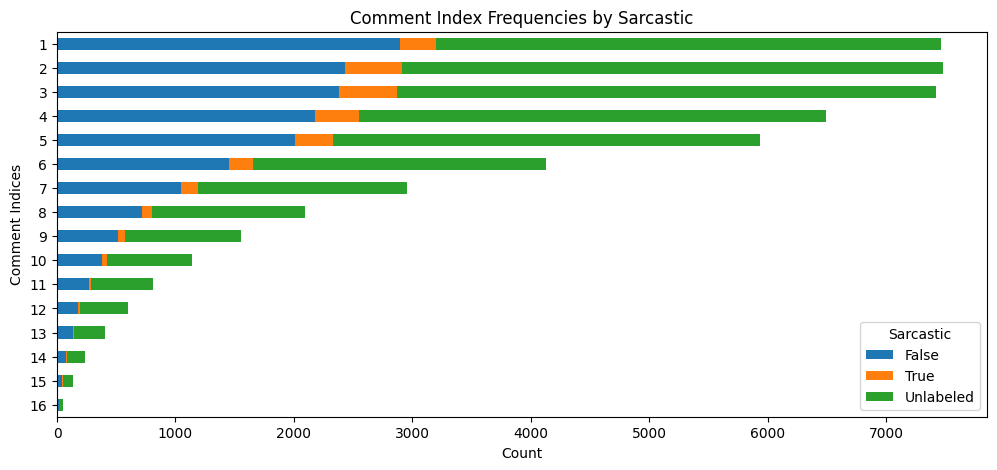

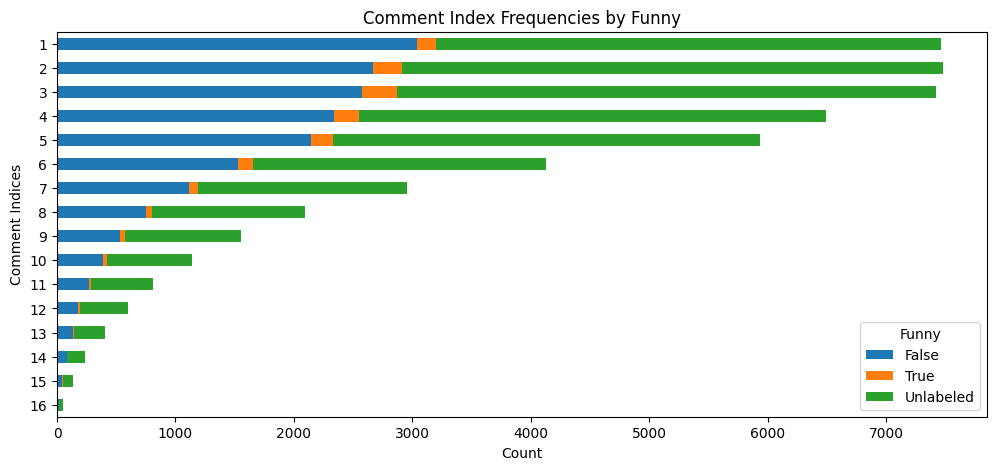

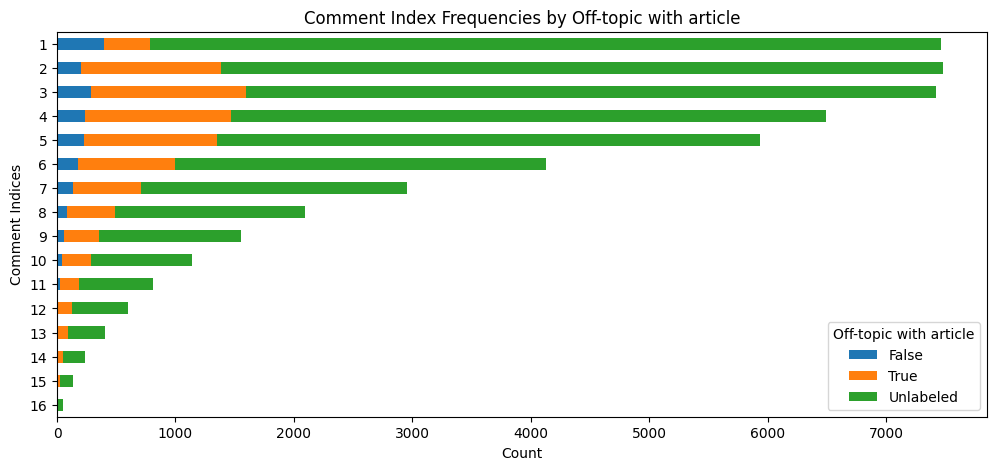

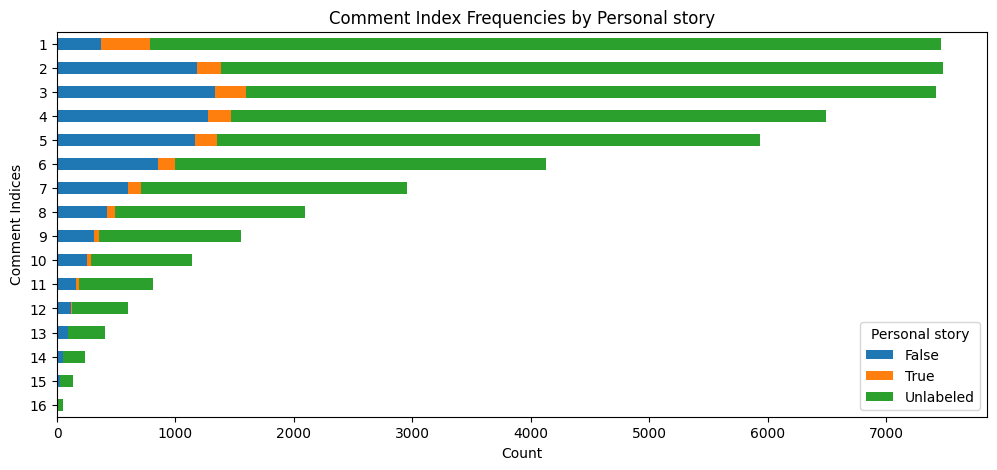

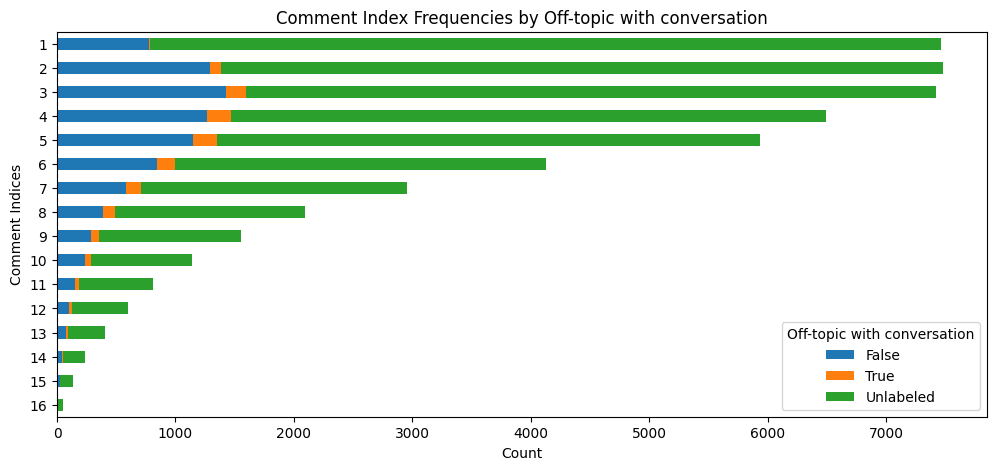

In [7]:
cols = ["tone", "topic"]
for column_name in cols:
    unique_values = list(yahoo_df[column_name].str.split(",").explode().unique())
    unique_values.remove(np.NaN)
    unique_values.remove("NA")

    for value in unique_values:
        data = yahoo_df.fillna("Unlabeled")
        data[value] = yahoo_df[column_name].str.contains(value)

        data = (
            data.fillna("Unlabeled")
            .groupby(["commentindex", value])["sdid"]
            .count()
            .reset_index()
        )
        data["commentindex"] += 1
        data = pd.pivot_table(
            data, values="sdid", index=["commentindex"], columns=[value]
        )
        data = data.sort_values(by="commentindex", ascending=False)

        fig, ax = plt.subplots(figsize=(12, 5))
        data.plot(kind="barh", stacked=True, ax=ax)
        ax.set(ylabel="Comment Indices", xlabel="Count")
        ax.set_title(f"Comment Index Frequencies by {value.capitalize()}")
plt.show()


### Baseline Model


In [8]:
import gensim
import gensim.downloader as api

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score


In [9]:
for df in [train_df, dev_df, test_df]:
    df["controversial"] = (
        df["tone"].str.contains("controversial", case=False).fillna(False).astype(str)
    )
    df["mean"] = df["tone"].str.contains("mean", case=False).fillna(False).astype(str)
    df["sarcastic"] = (
        df["tone"].str.contains("sarcastic", case=False).fillna(False).astype(str)
    )


In [10]:
w2v_model = api.load("word2vec-google-news-300")


def get_average_w2v_vector(row):
    words = row["text"].split()

    avg_text_w2v = np.sum([w2v_model[w] for w in words if w in w2v_model], axis=0) / (
        len(words) if words else 1
    )

    if avg_text_w2v.shape != (300,):
        avg_text_w2v = np.zeros((300,))

    return avg_text_w2v


baseline_scores = pd.DataFrame(columns=["Dataset", "Dev F1", "Test F1"])

for target_col, display_name in [
    ("persuasiveness", "Persuasiveness"),
    ("constructiveclass", "Constructiveness"),
    ("intendedaudience", "Intended Audience"),
    ("controversial", "Controversial"),
    ("mean", "Mean"),
    ("sarcastic", "Sarcastic"),
]:
    train_X = train_df.apply(
        lambda x: get_average_w2v_vector(x), axis=1, result_type="expand"
    )
    dev_X = dev_df.apply(
        lambda x: get_average_w2v_vector(x), axis=1, result_type="expand"
    )
    test_X = test_df.apply(
        lambda x: get_average_w2v_vector(x), axis=1, result_type="expand"
    )

    train_y = train_df[target_col]
    dev_y = dev_df[target_col]
    test_y = test_df[target_col]

    train_X = train_X[train_y.notna()]
    train_y = train_y[train_y.notna()]

    dev_X = dev_X[dev_y.notna()]
    dev_y = dev_y[dev_y.notna()]

    test_X = test_X[test_y.notna()]
    test_y = test_y[test_y.notna()]

    clf = LogisticRegression(max_iter=10000)
    clf.fit(train_X, train_y)

    pred_dev_y = clf.predict(dev_X)
    pred_test_y = clf.predict(test_X)

    baseline_scores.loc[len(baseline_scores.index)] = [
        display_name,
        f1_score(dev_y, pred_dev_y, average="weighted"),
        f1_score(test_y, pred_test_y, average="weighted"),
    ]


baseline_scores.round(2)


,Dataset,Dev F1,Test F1
0,Persuasiveness,0.72,0.75
1,Constructiveness,0.58,0.57
2,Intended Audience,0.57,0.65
3,Controversial,0.64,0.22
4,Mean,0.77,0.80
5,Sarcastic,0.87,0.81


### Baseline Model with Extractive Summary Features


In [11]:
from sumy.nlp.stemmers import Stemmer
from sumy.nlp.tokenizers import Tokenizer
from sumy.parsers.plaintext import PlaintextParser
from sumy.summarizers.lex_rank import LexRankSummarizer
from sumy.summarizers.lsa import LsaSummarizer
from sumy.summarizers.luhn import LuhnSummarizer
from sumy.summarizers.text_rank import TextRankSummarizer


In [12]:
class Summarizer:
    def __init__(self) -> None:
        self.language = "english"
        self.num_sentences = 3
        self.tokenizer = Tokenizer(self.language)
        self.stemmer = Stemmer(self.language)

    def summarize(self, thread: str) -> str:
        parser = PlaintextParser.from_string(thread, self.tokenizer)
        return "".join(
            (x._text for x in self.summarizer(parser.document, self.num_sentences))
        )


class Luhn(Summarizer):
    def __init__(self) -> None:
        super().__init__()
        self.summarizer = LuhnSummarizer()

    def __str__(self):
        return "Luhn"


class LSA(Summarizer):
    def __init__(self) -> None:
        super().__init__()
        self.summarizer = LsaSummarizer()

    def __str__(self):
        return "LSA"


class LexRank(Summarizer):
    def __init__(self) -> None:
        super().__init__()
        self.summarizer = LexRankSummarizer()

    def __str__(self):
        return "LexRank"


class TextRank(Summarizer):
    def __init__(self) -> None:
        super().__init__()
        self.summarizer = TextRankSummarizer()

    def __str__(self):
        return "TextRank"


summarizer_models = [Luhn(), LSA(), LexRank(), TextRank()]


In [13]:
w2v_model = api.load("word2vec-google-news-300")


def get_average_w2v_vector_thread(row):
    words = row["text"].split()
    summary_words = row["summary"].split()

    avg_text_w2v = np.sum([w2v_model[w] for w in words if w in w2v_model], axis=0) / (
        len(words) if words else 1
    )

    if avg_text_w2v.shape != (300,):
        avg_text_w2v = np.zeros((300,))

    avg_thread_w2v = np.sum(
        [w2v_model[w] for w in summary_words if w in w2v_model], axis=0
    ) / (len(summary_words) if summary_words else 1)

    if avg_thread_w2v.shape != (300,):
        avg_thread_w2v = np.zeros((300,))

    embedding = np.concatenate((avg_text_w2v, avg_thread_w2v), axis=None)
    return embedding


baseline_scores = pd.DataFrame(columns=["Summarizer", "Target", "Dev F1", "Test F1"])


for summarizer in summarizer_models:
    train_df["summary"] = train_df["thread"].apply(summarizer.summarize)
    dev_df["summary"] = dev_df["thread"].apply(summarizer.summarize)
    test_df["summary"] = test_df["thread"].apply(summarizer.summarize)

    for target_col, display_name in [
        ("persuasiveness", "Persuasiveness"),
        ("constructiveclass", "Constructiveness"),
        ("intendedaudience", "Intended Audience"),
        ("controversial", "Controversial"),
        ("mean", "Mean"),
        ("sarcastic", "Sarcastic"),
    ]:
        train_X = train_df.apply(
            lambda x: get_average_w2v_vector_thread(x), axis=1, result_type="expand"
        )
        dev_X = dev_df.apply(
            lambda x: get_average_w2v_vector_thread(x), axis=1, result_type="expand"
        )
        test_X = test_df.apply(
            lambda x: get_average_w2v_vector_thread(x), axis=1, result_type="expand"
        )

        train_y = train_df[target_col]
        dev_y = dev_df[target_col]
        test_y = test_df[target_col]

        train_X = train_X[train_y.notna()]
        train_y = train_y[train_y.notna()]

        dev_X = dev_X[dev_y.notna()]
        dev_y = dev_y[dev_y.notna()]

        test_X = test_X[test_y.notna()]
        test_y = test_y[test_y.notna()]

        clf = LogisticRegression(max_iter=10000)
        clf.fit(train_X, train_y)

        pred_dev_y = clf.predict(dev_X)
        pred_test_y = clf.predict(test_X)

        baseline_scores.loc[len(baseline_scores.index)] = [
            str(summarizer),
            display_name,
            f1_score(dev_y, pred_dev_y, average="weighted"),
            f1_score(test_y, pred_test_y, average="weighted"),
        ]

    train_df = train_df.drop(["summary"], axis=1)
    dev_df = dev_df.drop(["summary"], axis=1)
    test_df = test_df.drop(["summary"], axis=1)


baseline_scores.round(2)


,Summarizer,Target,Dev F1,Test F1
0,Luhn,Persuasiveness,0.73,0.75
1,Luhn,Constructiveness,0.62,0.61
2,Luhn,Intended Audience,0.56,0.65
3,Luhn,Controversial,0.64,0.24
4,Luhn,Mean,0.77,0.80
5,Luhn,Sarcastic,0.87,0.81
6,LSA,Persuasiveness,0.73,0.75
7,LSA,Constructiveness,0.62,0.61
8,LSA,Intended Audience,0.56,0.65
9,LSA,Controversial,0.64,0.24


The results above show essentially no changes aside from a small improvement for constructiveness. Constructiveness does have the most well-defined labels but maybe we need more complex features or models?


### Models with sentence embedding features


In [14]:
from sentence_transformers import SentenceTransformer

sbert_model = SentenceTransformer("stsb-distilroberta-base-v2")

train_sentence_embeddings = {}
dev_entence_embeddings = {}
test_sentence_embeddings = {}

train_sentence_embeddings["Base"] = sbert_model.encode(train_df["text"].to_list())
dev_entence_embeddings["Base"] = sbert_model.encode(dev_df["text"].to_list())
test_sentence_embeddings["Base"] = sbert_model.encode(test_df["text"].to_list())


In [16]:
for summarizer in summarizer_models:
    train_sentence_embeddings[str(summarizer)] = sbert_model.encode(
        train_df["thread"].apply(summarizer.summarize).to_list()
    )
    dev_entence_embeddings[str(summarizer)] = sbert_model.encode(
        dev_df["thread"].apply(summarizer.summarize).to_list()
    )
    test_sentence_embeddings[str(summarizer)] = sbert_model.encode(
        test_df["thread"].apply(summarizer.summarize).to_list()
    )


In [15]:
baseline_scores = pd.DataFrame(columns=["Dataset", "Dev F1", "Test F1"])


for target_col, display_name in [
    ("persuasiveness", "Persuasiveness"),
    ("constructiveclass", "Constructiveness"),
    ("intendedaudience", "Intended Audience"),
    ("controversial", "Controversial"),
    ("mean", "Mean"),
    ("sarcastic", "Sarcastic"),
]:
    train_X = train_sentence_embeddings["Base"].copy()
    dev_X = dev_entence_embeddings["Base"].copy()
    test_X = test_sentence_embeddings["Base"].copy()

    train_y = train_df[target_col]
    dev_y = dev_df[target_col]
    test_y = test_df[target_col]

    train_X = train_X[train_y.notna()]
    train_y = train_y[train_y.notna()]

    dev_X = dev_X[dev_y.notna()]
    dev_y = dev_y[dev_y.notna()]

    test_X = test_X[test_y.notna()]
    test_y = test_y[test_y.notna()]

    clf = LogisticRegression(max_iter=10000)
    clf.fit(train_X, train_y)

    pred_dev_y = clf.predict(dev_X)
    pred_test_y = clf.predict(test_X)

    baseline_scores.loc[len(baseline_scores.index)] = [
        display_name,
        f1_score(dev_y, pred_dev_y, average="weighted"),
        f1_score(test_y, pred_test_y, average="weighted"),
    ]


baseline_scores.round(2)


,Dataset,Dev F1,Test F1
0,Persuasiveness,0.77,0.81
1,Constructiveness,0.58,0.58
2,Intended Audience,0.68,0.72
3,Controversial,0.65,0.25
4,Mean,0.78,0.81
5,Sarcastic,0.87,0.81


In [17]:
baseline_scores = pd.DataFrame(columns=["Summarizer", "Target", "Dev F1", "Test F1"])

for summarizer in summarizer_models:
    for target_col, display_name in [
        ("persuasiveness", "Persuasiveness"),
        ("constructiveclass", "Constructiveness"),
        ("intendedaudience", "Intended Audience"),
        ("controversial", "Controversial"),
        ("mean", "Mean"),
        ("sarcastic", "Sarcastic"),
    ]:
        train_X = np.concatenate(
            (
                train_sentence_embeddings["Base"],
                train_sentence_embeddings[str(summarizer)],
            ),
            axis=1,
        )
        dev_X = np.concatenate(
            (dev_entence_embeddings["Base"], dev_entence_embeddings[str(summarizer)]),
            axis=1,
        )
        test_X = np.concatenate(
            (
                test_sentence_embeddings["Base"],
                test_sentence_embeddings[str(summarizer)],
            ),
            axis=1,
        )

        train_y = train_df[target_col]
        dev_y = dev_df[target_col]
        test_y = test_df[target_col]

        train_X = train_X[train_y.notna()]
        train_y = train_y[train_y.notna()]

        dev_X = dev_X[dev_y.notna()]
        dev_y = dev_y[dev_y.notna()]

        test_X = test_X[test_y.notna()]
        test_y = test_y[test_y.notna()]

        clf = LogisticRegression(max_iter=10000)
        clf.fit(train_X, train_y)

        pred_dev_y = clf.predict(dev_X)
        pred_test_y = clf.predict(test_X)

        baseline_scores.loc[len(baseline_scores.index)] = [
            str(summarizer),
            display_name,
            f1_score(dev_y, pred_dev_y, average="weighted"),
            f1_score(test_y, pred_test_y, average="weighted"),
        ]

baseline_scores.round(2)


,Summarizer,Target,Dev F1,Test F1
0,Luhn,Persuasiveness,0.75,0.77
1,Luhn,Constructiveness,0.57,0.58
2,Luhn,Intended Audience,0.66,0.73
3,Luhn,Controversial,0.65,0.37
4,Luhn,Mean,0.77,0.80
5,Luhn,Sarcastic,0.87,0.81
6,LSA,Persuasiveness,0.75,0.77
7,LSA,Constructiveness,0.57,0.58
8,LSA,Intended Audience,0.66,0.73
9,LSA,Controversial,0.65,0.37


### Trying out a better classification models with sentence embeddings features

In [24]:
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

In [26]:
baseline_scores = pd.DataFrame(columns=["Dataset", "Dev F1", "Test F1"])

enc = LabelEncoder()

for target_col, display_name in [
    ("persuasiveness", "Persuasiveness"),
    ("constructiveclass", "Constructiveness"),
    ("intendedaudience", "Intended Audience"),
    ("controversial", "Controversial"),
    ("mean", "Mean"),
    ("sarcastic", "Sarcastic"),
]:
    train_X = train_sentence_embeddings["Base"].copy()
    dev_X = dev_entence_embeddings["Base"].copy()
    test_X = test_sentence_embeddings["Base"].copy()

    train_y = train_df[target_col].copy()
    dev_y = dev_df[target_col].copy()
    test_y = test_df[target_col].copy()

    train_X = train_X[train_y.notna()]
    train_y = enc.fit_transform(train_y[train_y.notna()])

    dev_X = dev_X[dev_y.notna()]
    dev_y = enc.transform(dev_y[dev_y.notna()])

    test_X = test_X[test_y.notna()]
    test_y = enc.transform(test_y[test_y.notna()])

    clf = XGBClassifier()
    clf.fit(train_X, train_y)

    pred_dev_y = clf.predict(dev_X)
    pred_test_y = clf.predict(test_X)

    baseline_scores.loc[len(baseline_scores.index)] = [
        display_name,
        f1_score(dev_y, pred_dev_y, average="weighted"),
        f1_score(test_y, pred_test_y, average="weighted"),
    ]


baseline_scores.round(2)


,Dataset,Dev F1,Test F1
0,Persuasiveness,0.78,0.79
1,Constructiveness,0.56,0.55
2,Intended Audience,0.62,0.70
3,Controversial,0.64,0.27
4,Mean,0.77,0.81
5,Sarcastic,0.87,0.81


In [27]:
baseline_scores = pd.DataFrame(columns=["Summarizer", "Target", "Dev F1", "Test F1"])

for summarizer in summarizer_models:
    for target_col, display_name in [
        ("persuasiveness", "Persuasiveness"),
        ("constructiveclass", "Constructiveness"),
        ("intendedaudience", "Intended Audience"),
        ("controversial", "Controversial"),
        ("mean", "Mean"),
        ("sarcastic", "Sarcastic"),
    ]:
        train_X = np.concatenate(
            (
                train_sentence_embeddings["Base"],
                train_sentence_embeddings[str(summarizer)],
            ),
            axis=1,
        )
        dev_X = np.concatenate(
            (dev_entence_embeddings["Base"], dev_entence_embeddings[str(summarizer)]),
            axis=1,
        )
        test_X = np.concatenate(
            (
                test_sentence_embeddings["Base"],
                test_sentence_embeddings[str(summarizer)],
            ),
            axis=1,
        )

        train_y = train_df[target_col]
        dev_y = dev_df[target_col]
        test_y = test_df[target_col]

        train_X = train_X[train_y.notna()]
        train_y = enc.fit_transform(train_y[train_y.notna()])

        dev_X = dev_X[dev_y.notna()]
        dev_y = enc.transform(dev_y[dev_y.notna()])

        test_X = test_X[test_y.notna()]
        test_y = enc.transform(test_y[test_y.notna()])

        clf = XGBClassifier()
        clf.fit(train_X, train_y)

        pred_dev_y = clf.predict(dev_X)
        pred_test_y = clf.predict(test_X)

        baseline_scores.loc[len(baseline_scores.index)] = [
            str(summarizer),
            display_name,
            f1_score(dev_y, pred_dev_y, average="weighted"),
            f1_score(test_y, pred_test_y, average="weighted"),
        ]

baseline_scores.round(2)


,Summarizer,Target,Dev F1,Test F1
0,Luhn,Persuasiveness,0.76,0.80
1,Luhn,Constructiveness,0.59,0.55
2,Luhn,Intended Audience,0.77,0.83
3,Luhn,Controversial,0.64,0.22
4,Luhn,Mean,0.78,0.80
5,Luhn,Sarcastic,0.87,0.81
6,LSA,Persuasiveness,0.76,0.80
7,LSA,Constructiveness,0.59,0.55
8,LSA,Intended Audience,0.77,0.83
9,LSA,Controversial,0.64,0.22
